In [1]:
import os
os.environ["HF_HUB_ENABLE_PICKLE_EXPERIMENTAL"] = "1"
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

from dataclasses import dataclass
from pathlib import Path
from typing import List, Optional, Dict, Any

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm

from diffusers import StableDiffusionInpaintPipeline, DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup

from peft import LoraConfig
from peft.utils import get_peft_model_state_dict
import random

c:\Users\SyedM\miniconda3\envs\lora_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\Users\SyedM\miniconda3\envs\lora_env\lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
ModuleNotFoundError: No module named 'triton'


In [2]:
# -----------------------------
# Config
# -----------------------------
@dataclass
class TrainConfig:
    model_id: str = "stable-diffusion-v1-5/stable-diffusion-inpainting"
    base_dir: Path = Path(".")
    image_size: int = 512

    train_batch_size: int = 2
    num_epochs: int = 1
    max_train_steps: int = 2000
    learning_rate: float = 1e-4  # LoRA often tolerates higher LR than full finetune
    lr_warmup_steps: int = 50
    gradient_accumulation_steps: int = 1
    max_grad_norm: float = 1.0

    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    mixed_precision: str = "fp16"  # "fp16" or "bf16"

    output_dir: Path = Path("lora_inpainting")
    seed: int = 42

cfg = TrainConfig()
cfg.output_dir.mkdir(parents=True, exist_ok=True)


In [3]:
# -----------------------------
# Dataset class (file-list driven)
# -----------------------------
class InpaintingLoraDataset(Dataset):
    def __init__(
        self,
        base_dir: Path,
        files: List[Path],
        image_size: int = 512,
        prompt: Optional[str] = None
    ):
        self.prepared_dir = base_dir / "prepared"
        self.orig_dir = self.prepared_dir / "original"
        self.dmg_dir  = self.prepared_dir / "inpainting" / "input"
        self.mask_dir = self.prepared_dir / "inpainting" / "mask"

        self.files = files
        self.image_size = image_size

        self.img_tf = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
        ])
        self.to_sd = transforms.Normalize([0.5, 0.5, 0.5],
                                          [0.5, 0.5, 0.5])  # -> [-1, 1]

        self.mask_resize = transforms.Resize(
            (image_size, image_size),
            interpolation=transforms.InterpolationMode.NEAREST
        )

        self.prompt = prompt or (
            "restore the missing regions realistically, "
            "continuous surfaces, natural textures, "
            "matching colors and lighting, no text, no watermark"
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx].name

        orig = Image.open(self.orig_dir / fname).convert("RGB")
        dmg  = Image.open(self.dmg_dir  / fname).convert("RGB")
        mask = Image.open(self.mask_dir / fname).convert("L")

        orig = self.to_sd(self.img_tf(orig))
        dmg  = self.to_sd(self.img_tf(dmg))

        mask = self.mask_resize(mask)
        mask = transforms.ToTensor()(mask)  # [1,H,W], 0..1
        mask = (mask > 0.5).float()

        return {
            "original": orig,
            "damaged": dmg,
            "mask": mask,
            "prompt": self.prompt,
            "fname": fname,
        }


In [4]:
# -----------------------------
# Build manifest of valid pairs
# -----------------------------

def list_inpaint_pairs(base_dir: Path) -> List[Path]:
    prepared_dir = base_dir / "prepared"
    orig_dir = prepared_dir / "original"
    dmg_dir  = prepared_dir / "inpainting" / "input"
    mask_dir = prepared_dir / "inpainting" / "mask"

    files = sorted(
        f for f in orig_dir.iterdir()
        if f.suffix.lower() in {".png", ".jpg", ".jpeg"}
        and (dmg_dir / f.name).exists()
        and (mask_dir / f.name).exists()
    )
    return files


# -----------------------------
# Split utility
# -----------------------------

def split_files(
    files: List[Path],
    train_ratio=0.90,
    val_ratio=0.05,
    test_ratio=0.05,
    seed=42
):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

    files = files.copy()
    random.Random(seed).shuffle(files)

    n = len(files)
    n_train = int(n * train_ratio)
    n_val   = int(n * val_ratio)

    train_files = files[:n_train]
    val_files   = files[n_train:n_train + n_val]
    test_files  = files[n_train + n_val:]

    return train_files, val_files, test_files


# -----------------------------
# Create splits
# -----------------------------

base_dir = cfg.base_dir if "cfg" in globals() else Path(".")

all_files = list_inpaint_pairs(base_dir)
print("Total valid inpaint pairs:", len(all_files))

train_files, val_files, test_files = split_files(
    all_files,
    train_ratio=0.90,
    val_ratio=0.05,
    test_ratio=0.05,
    seed=cfg.seed if "cfg" in globals() else 42
)

print(f"Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")

# OPTIONAL: sanity check no overlap
train_set = set(f.name for f in train_files)
val_set   = set(f.name for f in val_files)
test_set  = set(f.name for f in test_files)

print("Overlap train/val:", len(train_set & val_set))
print("Overlap train/test:", len(train_set & test_set))
print("Overlap val/test:", len(val_set & test_set))


# -----------------------------
# Build datasets
# -----------------------------

train_ds = InpaintingLoraDataset(base_dir, train_files, image_size=cfg.image_size)
val_ds   = InpaintingLoraDataset(base_dir, val_files,   image_size=cfg.image_size)
test_ds  = InpaintingLoraDataset(base_dir, test_files,  image_size=cfg.image_size)

# -----------------------------
# DataLoaders
# -----------------------------

train_loader = DataLoader(
    train_ds,
    batch_size=cfg.train_batch_size,
    shuffle=True,
    num_workers=0,     # safest on Windows
    pin_memory=(cfg.device == "cuda")
)

val_loader = DataLoader(
    val_ds,
    batch_size=cfg.train_batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=(cfg.device == "cuda")
)

test_loader = DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

print("Loaders ready.")

Total valid inpaint pairs: 92858
Train: 83572 | Val: 4642 | Test: 4644
Overlap train/val: 0
Overlap train/test: 0
Overlap val/test: 0
Loaders ready.


In [5]:
# -----------------------------
# Setup
# -----------------------------
torch.manual_seed(cfg.seed)

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    cfg.model_id,
    torch_dtype=torch.float16 if (cfg.device == "cuda" and cfg.mixed_precision == "fp16") else torch.float32,
)
pipe.to(cfg.device)

unet = pipe.unet
vae = pipe.vae
text_encoder = pipe.text_encoder
tokenizer = pipe.tokenizer

# IMPORTANT: training noise scheduler
noise_scheduler = DDPMScheduler.from_pretrained(cfg.model_id, subfolder="scheduler")  # :contentReference[oaicite:2]{index=2}

# Freeze base weights
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

# Add LoRA (PEFT)
unet_lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    init_lora_weights="gaussian",
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],
)
unet.add_adapter(unet_lora_config)  # official pattern :contentReference[oaicite:3]{index=3}

# Upcast trainable LoRA params to fp32 for stability if using fp16
trainable_params = []
for p in unet.parameters():
    if p.requires_grad:
        p.data = p.data.to(torch.float32)
        trainable_params.append(p)

print("Trainable LoRA params:", sum(p.numel() for p in trainable_params))


# train_ds, val_ds, test_ds created in the split cell
print("Train size:", len(train_ds))
print("Val size:", len(val_ds))
print("Test size:", len(test_ds))


optimizer = torch.optim.AdamW(trainable_params, lr=cfg.learning_rate)

# compute training steps correctly
steps_per_epoch = max(1, len(train_loader) // cfg.gradient_accumulation_steps)
max_train_steps = min(cfg.max_train_steps, cfg.num_epochs * steps_per_epoch)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=cfg.lr_warmup_steps,
    num_training_steps=max_train_steps,
)

from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler(enabled=(cfg.device == "cuda" and cfg.mixed_precision == "fp16"))


def encode_latents(img: torch.Tensor) -> torch.Tensor:
    img = img.to(cfg.device, dtype=vae.dtype)
    latents = vae.encode(img).latent_dist.sample()
    latents = latents * 0.18215
    return latents


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]An error occurred while trying to fetch C:\Users\SyedM\.cache\huggingface\hub\models--stable-diffusion-v1-5--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\vae: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\SyedM\.cache\huggingface\hub\models--stable-diffusion-v1-5--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:00,  5.85it/s]An error occurred while trying to fetch C:\Users\SyedM\.cache\huggingface\hub\models--stable-diffusion-v1-5--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\SyedM\.cache\huggingface\hub\models--stable-diffusion-v1-5--stable

Trainable LoRA params: 1594368
Train size: 83572
Val size: 4642
Test size: 4644


C:\Users\SyedM\AppData\Local\Temp\ipykernel_17804\169349685.py:63: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(cfg.device == "cuda" and cfg.mixed_precision == "fp16"))


In [6]:
# -----------------------------
# Training loop
# -----------------------------
unet.train()
global_step = 0
progress = tqdm(total=max_train_steps, desc="LoRA Inpaint Training")

optimizer.zero_grad(set_to_none=True)

for epoch in range(cfg.num_epochs):
    for batch in train_loader:
        if global_step >= max_train_steps:
            break

        with torch.no_grad():
            orig = batch["original"].to(cfg.device)
            dmg = batch["damaged"].to(cfg.device)
            mask = batch["mask"].to(cfg.device)
            prompts = batch["prompt"]

            with autocast(enabled=(cfg.device == "cuda")):
                orig_latents = encode_latents(orig)
                dmg_latents = encode_latents(dmg)

            noise = torch.randn_like(orig_latents)
            bsz = orig_latents.shape[0]
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bsz,),
                device=orig_latents.device, dtype=torch.long
            )

            noisy_latents = noise_scheduler.add_noise(orig_latents, noise, timesteps)

            mask_latents = torch.nn.functional.interpolate(
                mask, size=noisy_latents.shape[-2:], mode="nearest"
            )

            # SD inpaint UNet expects 9 channels input:
            # [noisy_latents (4), mask (1), masked_image_latents (4)]
            latent_model_input = torch.cat([noisy_latents, mask_latents, dmg_latents], dim=1)

            text_inputs = tokenizer(
                prompts,
                padding="max_length",
                max_length=tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt"
            )
            text_emb = text_encoder(text_inputs.input_ids.to(cfg.device))[0]

        with autocast(enabled=(cfg.device == "cuda")):
            model_pred = unet(
                latent_model_input,
                timesteps,
                encoder_hidden_states=text_emb,
            ).sample

            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(orig_latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction_type {noise_scheduler.config.prediction_type}")

            loss = nn.functional.mse_loss(model_pred.float(), target.float(), reduction="mean")
            loss = loss / cfg.gradient_accumulation_steps

        scaler.scale(loss).backward()

        # step only on accumulation boundary
        if (global_step + 1) % cfg.gradient_accumulation_steps == 0:
            # unscale -> clip -> step
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(trainable_params, cfg.max_grad_norm)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

            lr_scheduler.step()  # <-- you were missing this

        global_step += 1
        progress.update(1)
        progress.set_postfix(loss=float(loss.item() * cfg.gradient_accumulation_steps))

progress.close()
print("Training complete. Global steps:", global_step)

LoRA Inpaint Training:   0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\SyedM\AppData\Local\Temp\ipykernel_17804\1198057594.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(cfg.device == "cuda")):
C:\Users\SyedM\AppData\Local\Temp\ipykernel_17804\1198057594.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(cfg.device == "cuda")):
LoRA Inpaint Training: 100%|██████████| 2000/2000 [1:41:57<00:00,  3.06s/it, loss=0.0476]      

Training complete. Global steps: 2000


In [7]:
# -----------------------------
# Save LoRA weights
# -----------------------------
unet_lora_state_dict = get_peft_model_state_dict(unet)

StableDiffusionInpaintPipeline.save_lora_weights(
    save_directory=cfg.output_dir,
    unet_lora_layers=unet_lora_state_dict,
    safe_serialization=True
)
print("Saved LoRA weights to:", cfg.output_dir)


Saved LoRA weights to: lora_inpainting


In [8]:
# Cell 9 (Improved): Load base & LoRA pipelines for comparison

import os
import torch
from diffusers import StableDiffusionInpaintPipeline

# Reuse env flags
os.environ["HF_HUB_ENABLE_PICKLE_EXPERIMENTAL"] = "1"
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

device = cfg.device
model_id = cfg.model_id
lora_dir = cfg.output_dir

dtype = torch.float16 if device == "cuda" else torch.float32

# Base pipeline (no LoRA)
pipe_base = StableDiffusionInpaintPipeline.from_pretrained(
    model_id,
    torch_dtype=dtype,
).to(device)

# LoRA pipeline
pipe_lora = StableDiffusionInpaintPipeline.from_pretrained(
    model_id,
    torch_dtype=dtype,
).to(device)

# Load LoRA weights
pipe_lora.load_lora_weights(lora_dir)

# Optional performance tweaks
for p in (pipe_base, pipe_lora):
    try:
        p.enable_attention_slicing()
    except Exception:
        pass
    if device == "cuda":
        try:
            p.enable_xformers_memory_efficient_attention()
        except Exception:
            pass

# Optional: disable safety checker for local experiments
# (only if your environment allows it and you're not deploying)
try:
    pipe_base.safety_checker = None
    pipe_lora.safety_checker = None
except Exception:
    pass

print("Base and LoRA pipelines ready on", device)
print("LoRA directory:", lora_dir)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]An error occurred while trying to fetch C:\Users\SyedM\.cache\huggingface\hub\models--stable-diffusion-v1-5--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\vae: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\SyedM\.cache\huggingface\hub\models--stable-diffusion-v1-5--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:01,  4.13it/s]An error occurred while trying to fetch C:\Users\SyedM\.cache\huggingface\hub\models--stable-diffusion-v1-5--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\SyedM\.cache\huggingface\hub\models--stable-diffusion-v1-5--stable

Base and LoRA pipelines ready on cuda
LoRA directory: lora_inpainting


In [9]:
# Cell 10 (Improved): Pick random test images (deterministic)

import random
from pathlib import Path

base_dir = cfg.base_dir

prepared_dir = base_dir / "prepared"
orig_dir = prepared_dir / "original"
dmg_dir = prepared_dir / "inpainting" / "input"
mask_dir = prepared_dir / "inpainting" / "mask"

all_damaged = sorted(
    f for f in dmg_dir.iterdir()
    if f.suffix.lower() in {".png", ".jpg", ".jpeg"}
    and (mask_dir / f.name).exists()
    and (orig_dir / f.name).exists()
)

print("Total pairs available:", len(all_damaged))

# Reproducible sample list
random.seed(123)
num_samples = 12  # keep smaller for faster interactive runs
sample_files = random.sample(all_damaged, min(num_samples, len(all_damaged)))

print("Sampling:")
for p in sample_files:
    print(" -", p.name)


Total pairs available: 92858
Sampling:
 - test-00001-of-00028_003291.png
 - test-00009-of-00028_002936.png
 - test-00003-of-00028_000711.png
 - test-00014-of-00028_003371.png
 - test-00009-of-00028_002789.png
 - test-00003-of-00028_003400.png
 - test-00001-of-00028_001428.png
 - test-00013-of-00028_003257.png
 - test-00019-of-00028_002420.png
 - test-00020-of-00028_002272.png
 - test-00012-of-00028_000677.png
 - test-00012-of-00028_001805.png


100%|██████████| 28/28 [00:01<00:00, 20.83it/s]


  Masked   Base PSNR=16.77 SSIM=0.882 | LoRA PSNR=17.13 SSIM=0.887
  Global   Base PSNR=23.51 SSIM=0.763 | LoRA PSNR=23.63 SSIM=0.762
File: test-00001-of-00028_003291.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


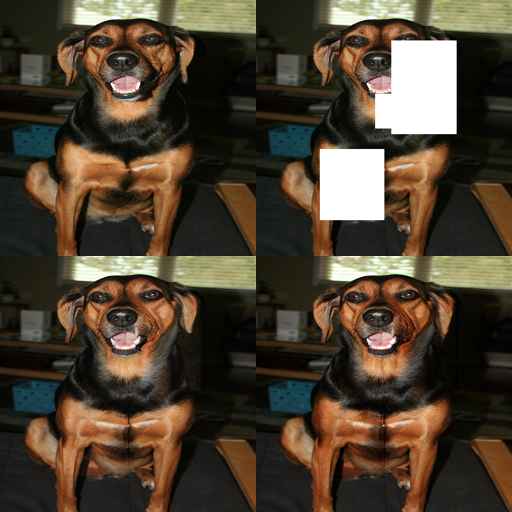

100%|██████████| 28/28 [00:01<00:00, 21.10it/s]


  Masked   Base PSNR=10.54 SSIM=0.775 | LoRA PSNR=10.34 SSIM=0.776
  Global   Base PSNR=12.78 SSIM=0.284 | LoRA PSNR=12.61 SSIM=0.282
File: test-00009-of-00028_002936.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


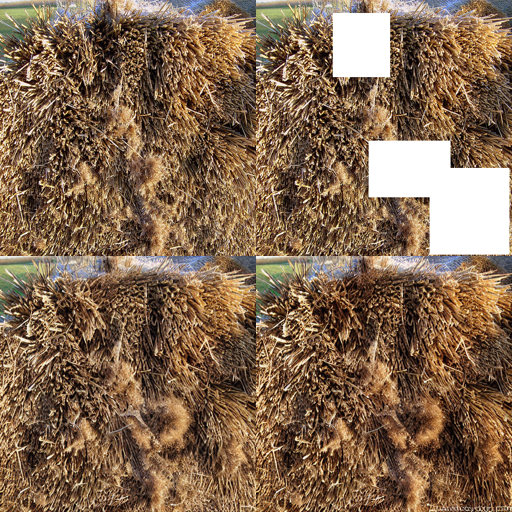

100%|██████████| 28/28 [00:01<00:00, 21.02it/s]


  Masked   Base PSNR=11.28 SSIM=0.828 | LoRA PSNR=11.39 SSIM=0.830
  Global   Base PSNR=15.49 SSIM=0.437 | LoRA PSNR=15.48 SSIM=0.435
File: test-00003-of-00028_000711.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


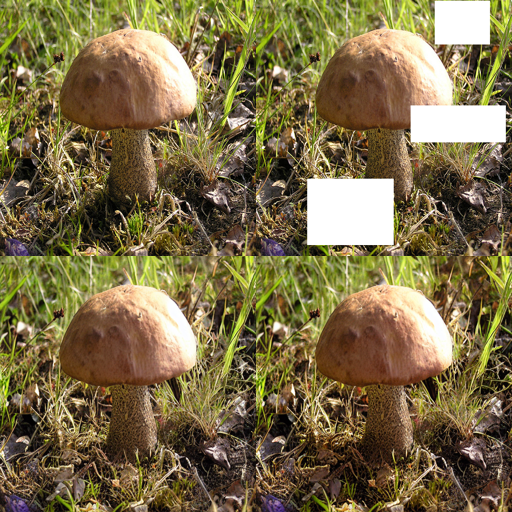

100%|██████████| 28/28 [00:01<00:00, 21.48it/s]


  Masked   Base PSNR=12.47 SSIM=0.815 | LoRA PSNR=13.46 SSIM=0.843
  Global   Base PSNR=18.49 SSIM=0.732 | LoRA PSNR=19.38 SSIM=0.750
File: test-00014-of-00028_003371.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


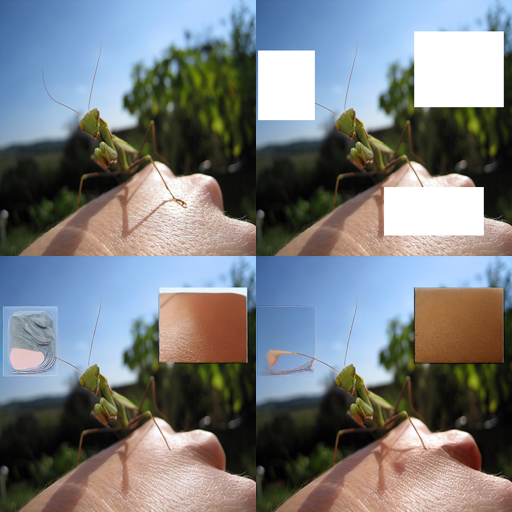

100%|██████████| 28/28 [00:01<00:00, 21.69it/s]


  Masked   Base PSNR=21.60 SSIM=0.896 | LoRA PSNR=14.02 SSIM=0.887
  Global   Base PSNR=26.42 SSIM=0.743 | LoRA PSNR=21.42 SSIM=0.731
File: test-00009-of-00028_002789.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


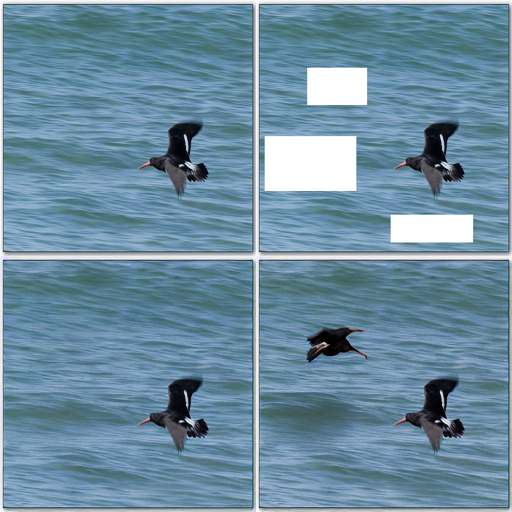

100%|██████████| 28/28 [00:01<00:00, 20.50it/s]


  Masked   Base PSNR=9.74 SSIM=0.896 | LoRA PSNR=8.40 SSIM=0.881
  Global   Base PSNR=18.12 SSIM=0.721 | LoRA PSNR=16.79 SSIM=0.701
File: test-00003-of-00028_003400.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


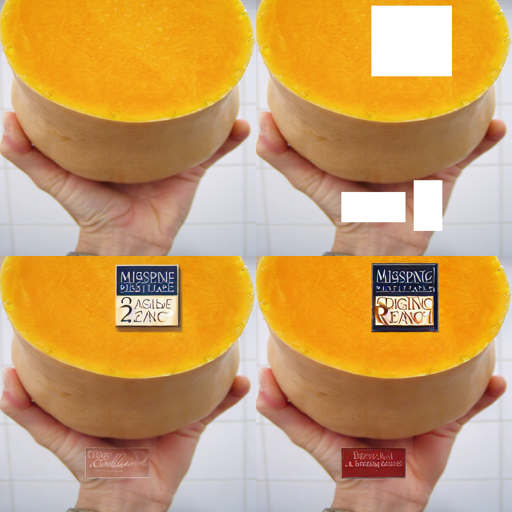

100%|██████████| 28/28 [00:01<00:00, 21.56it/s]


  Masked   Base PSNR=7.25 SSIM=0.825 | LoRA PSNR=9.13 SSIM=0.819
  Global   Base PSNR=14.56 SSIM=0.547 | LoRA PSNR=16.30 SSIM=0.487
File: test-00001-of-00028_001428.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


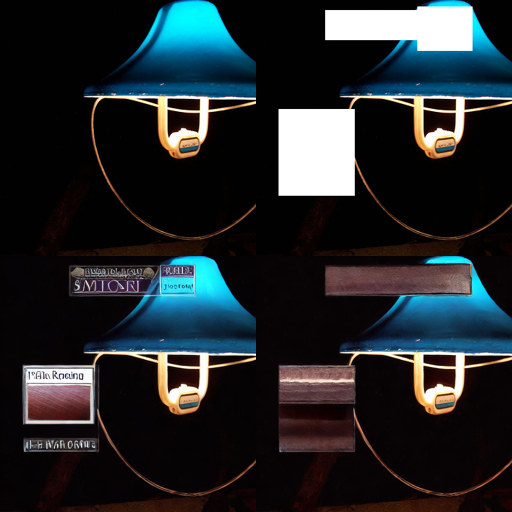

100%|██████████| 28/28 [00:01<00:00, 21.83it/s]


  Masked   Base PSNR=13.07 SSIM=0.810 | LoRA PSNR=11.66 SSIM=0.794
  Global   Base PSNR=18.16 SSIM=0.609 | LoRA PSNR=16.86 SSIM=0.589
File: test-00013-of-00028_003257.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


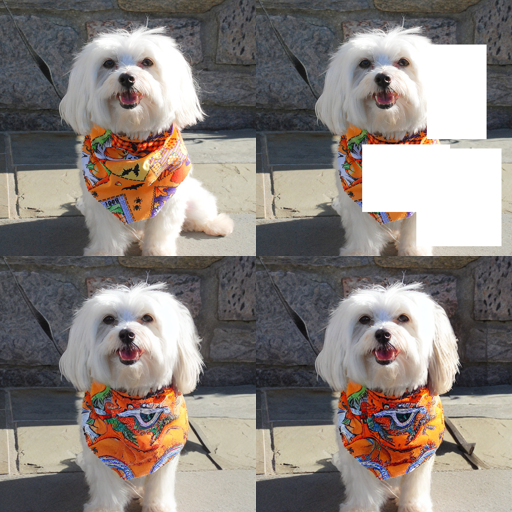

100%|██████████| 28/28 [00:01<00:00, 21.39it/s]


  Masked   Base PSNR=11.62 SSIM=0.854 | LoRA PSNR=17.17 SSIM=0.886
  Global   Base PSNR=19.07 SSIM=0.742 | LoRA PSNR=23.67 SSIM=0.769
File: test-00019-of-00028_002420.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


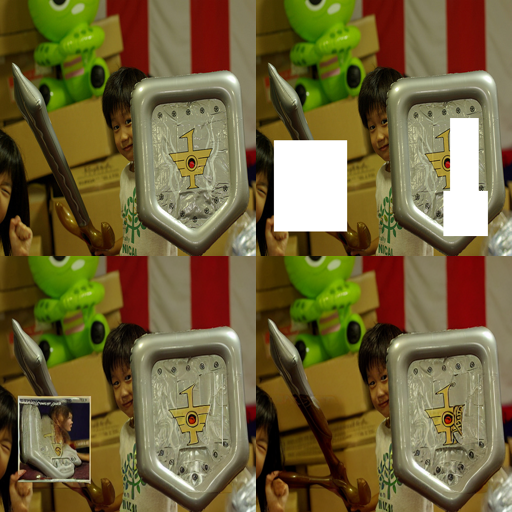

100%|██████████| 28/28 [00:01<00:00, 22.26it/s]


  Masked   Base PSNR=12.76 SSIM=0.854 | LoRA PSNR=11.29 SSIM=0.847
  Global   Base PSNR=18.87 SSIM=0.770 | LoRA PSNR=17.50 SSIM=0.757
File: test-00020-of-00028_002272.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


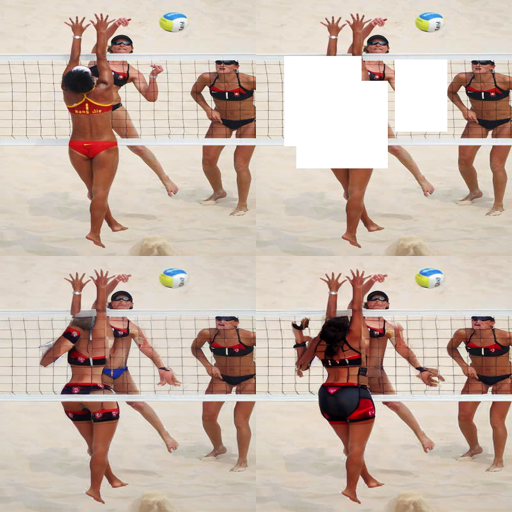

100%|██████████| 28/28 [00:01<00:00, 21.67it/s]


  Masked   Base PSNR=18.46 SSIM=0.953 | LoRA PSNR=15.67 SSIM=0.946
  Global   Base PSNR=24.26 SSIM=0.800 | LoRA PSNR=22.91 SSIM=0.790
File: test-00012-of-00028_000677.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


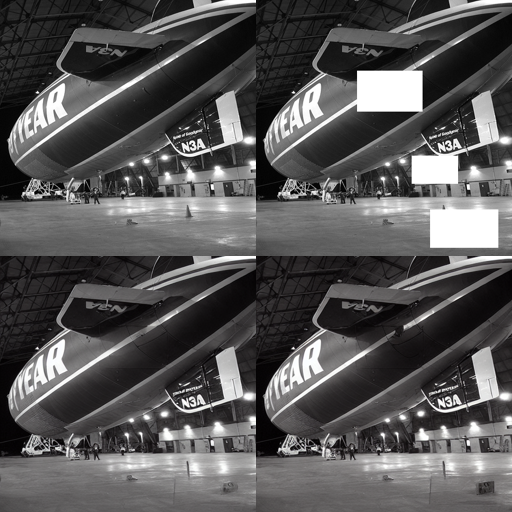

100%|██████████| 28/28 [00:01<00:00, 21.80it/s]


  Masked   Base PSNR=16.00 SSIM=0.880 | LoRA PSNR=11.41 SSIM=0.842
  Global   Base PSNR=20.82 SSIM=0.830 | LoRA PSNR=16.43 SSIM=0.788
File: test-00012-of-00028_001805.png
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA


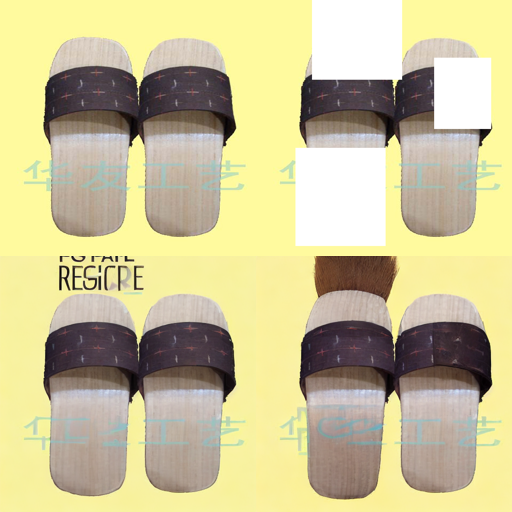

In [10]:
# Cell 11: Run base + LoRA inpainting + masked metrics + DISPLAY side-by-side

import numpy as np
import torch
from PIL import Image
from IPython.display import display
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# -----------------------------
# Prompts / inference settings
# -----------------------------
clean_prompt = (
    "restore the missing regions realistically, "
    "continuous surfaces, natural textures, matching colors, "
    "similar lighting, similar background, no text, no watermark"
)

negative_prompt = (
    "text, letters, watermark, logo, caption, subtitles, UI, user interface, random characters, "
    "colored blocks, script, computer window, dialog box, buttons, icons, menu bar, sign, poster, "
    "bad artifacts, low quality, deformed, blurry, cropped, ugly"
)

num_inference_steps = 28
guidance_scale = 6
seed = 12345  # fixed seed so base vs LoRA comparable

# If you did NOT fuse LoRA, you can adjust scale here
lora_scale = 1.0

# -----------------------------
# Helper: global metrics (optional)
# -----------------------------
def global_metrics(pred: Image.Image, gt: Image.Image):
    if pred.size != gt.size:
        gt = gt.resize(pred.size, resample=Image.LANCZOS)

    p = np.array(pred).astype(np.float32)
    g = np.array(gt).astype(np.float32)

    psnr = peak_signal_noise_ratio(g, p, data_range=255)
    ssim = structural_similarity(g, p, channel_axis=2, data_range=255)
    return psnr, ssim

# -----------------------------
# Helper: masked metrics (recommended)
# -----------------------------
def masked_metrics(pred: Image.Image, gt: Image.Image, mask: Image.Image):
    """
    Computes:
    - Masked PSNR on only the inpaint region pixels
    - Focused SSIM using a proxy that highlights the inpaint area

    Mask semantics:
    - White/1 = region to inpaint (evaluate here)
    """

    # Align sizes to prediction
    if gt.size != pred.size:
        gt = gt.resize(pred.size, resample=Image.LANCZOS)
    if mask.size != pred.size:
        mask = mask.resize(pred.size, resample=Image.NEAREST)

    # Convert to arrays
    p = np.array(pred).astype(np.float32)
    g = np.array(gt).astype(np.float32)

    # Mask to {0,1}
    m = np.array(mask.convert("L")).astype(np.float32) / 255.0
    m = (m > 0.5).astype(np.float32)  # binarize

    # If mask is too small/empty, fall back to global
    if m.sum() < 10:
        psnr = peak_signal_noise_ratio(g, p, data_range=255)
        ssim = structural_similarity(g, p, channel_axis=2, data_range=255)
        return psnr, ssim

    # Expand mask to 3 channels
    m3 = np.repeat(m[..., None], 3, axis=2)

    # Extract masked pixels for PSNR
    p_masked = p[m3 == 1].reshape(-1, 3)
    g_masked = g[m3 == 1].reshape(-1, 3)

    mse = np.mean((p_masked - g_masked) ** 2)
    psnr = float("inf") if mse == 0 else 20 * np.log10(255.0 / np.sqrt(mse))

    # Focused SSIM proxy:
    # Replace unmasked area in pred with GT so SSIM is driven mainly by mask region
    p_focus = p * m3 + g * (1 - m3)
    ssim = structural_similarity(g, p_focus, channel_axis=2, data_range=255)

    return psnr, ssim

# -----------------------------
# Helper: run inpaint
# -----------------------------
def run_inpaint(pipe, damaged, mask, prompt, negative, steps, guidance, seed):
    gen = torch.Generator(device=device).manual_seed(seed)

    # If LoRA is loaded but not fused, you can control scale:
    if hasattr(pipe, "set_adapters"):
        try:
            pipe.set_adapters(["default"], [lora_scale])
        except Exception:
            pass

    out = pipe(
        prompt=prompt,
        negative_prompt=negative,
        image=damaged,
        mask_image=mask,
        num_inference_steps=steps,
        guidance_scale=guidance,
        generator=gen,
    ).images[0]

    return out

# -----------------------------
# Helper: show 2x2 grid
# -----------------------------
def show_comparison(name: str, orig, dmg, base, lora):
    size = (256, 256)
    orig_r = orig.resize(size)
    dmg_r = dmg.resize(size)
    base_r = base.resize(size)
    lora_r = lora.resize(size)

    grid = Image.new("RGB", (size[0] * 2, size[1] * 2), "white")
    grid.paste(orig_r, (0, 0))
    grid.paste(dmg_r, (size[0], 0))
    grid.paste(base_r, (0, size[1]))
    grid.paste(lora_r, (size[0], size[1]))

    print(f"File: {name}")
    print("Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA")
    display(grid)

# -----------------------------
# Main loop
# -----------------------------
for dmg_path in sample_files:
    fname = dmg_path.name
    orig_path = orig_dir / fname
    mask_path = mask_dir / fname

    orig = Image.open(orig_path).convert("RGB")
    damaged = Image.open(dmg_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    # Ensure mask matches damaged for inference
    if mask.size != damaged.size:
        mask = mask.resize(damaged.size, resample=Image.NEAREST)

    # Base model output
    out_base = run_inpaint(
        pipe_base, damaged, mask,
        clean_prompt, negative_prompt,
        num_inference_steps, guidance_scale, seed
    )

    # LoRA model output
    out_lora = run_inpaint(
        pipe_lora, damaged, mask,
        clean_prompt, negative_prompt,
        num_inference_steps, guidance_scale, seed
    )

    # -----------------------------
    # Metrics
    # -----------------------------
    # Masked metrics (best for inpainting)
    m_psnr_b, m_ssim_b = masked_metrics(out_base, orig, mask)
    m_psnr_l, m_ssim_l = masked_metrics(out_lora, orig, mask)

    # Optional global metrics (often less sensitive)
    g_psnr_b, g_ssim_b = global_metrics(out_base, orig)
    g_psnr_l, g_ssim_l = global_metrics(out_lora, orig)

    print(
        f"  Masked   Base PSNR={m_psnr_b:.2f} SSIM={m_ssim_b:.3f} | "
        f"LoRA PSNR={m_psnr_l:.2f} SSIM={m_ssim_l:.3f}"
    )
    print(
        f"  Global   Base PSNR={g_psnr_b:.2f} SSIM={g_ssim_b:.3f} | "
        f"LoRA PSNR={g_psnr_l:.2f} SSIM={g_ssim_l:.3f}"
    )

    # -----------------------------
    # Visual comparison
    # -----------------------------
    show_comparison(fname, orig, damaged, out_base, out_lora)


In [11]:
# =============================
# Inpainting Evaluation (Base vs LoRA)
# Aggregated masked metrics + qualitative best/worst grids
# =============================
import os
import random
from pathlib import Path

import numpy as np
import torch
import pandas as pd
from PIL import Image

from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from IPython.display import display

# -----------------------------
# Resolve dirs robustly
# -----------------------------
# Assumes you already have cfg with cfg.base_dir, cfg.model_id, cfg.output_dir
# If not, you can set base_dir manually here.

base_dir = getattr(cfg, "base_dir", Path("."))
prepared_dir = Path(base_dir) / "prepared"
orig_dir = prepared_dir / "original"
dmg_dir  = prepared_dir / "inpainting" / "input"
mask_dir = prepared_dir / "inpainting" / "mask"

assert orig_dir.exists(), f"Missing: {orig_dir}"
assert dmg_dir.exists(), f"Missing: {dmg_dir}"
assert mask_dir.exists(), f"Missing: {mask_dir}"

# -----------------------------
# Prompts / inference settings
# -----------------------------
clean_prompt = (
    "restore the missing regions realistically, "
    "continuous surfaces, natural textures, matching colors, "
    "similar lighting, similar background, no text, no watermark"
)

negative_prompt = (
    "text, letters, watermark, logo, caption, subtitles, UI, user interface, random characters, "
    "colored blocks, script, computer window, dialog box, buttons, icons, menu bar, sign, poster, "
    "bad artifacts, low quality, deformed, blurry, cropped, ugly"
)

num_inference_steps = 28
guidance_scale = 6.0
seed = 12345

# For LoRA scaling (if your pipe supports set_adapters)
DEFAULT_LORA_SCALE = 1.0

# -----------------------------
# Metric helpers
# -----------------------------
def global_metrics(pred: Image.Image, gt: Image.Image):
    if pred.size != gt.size:
        gt = gt.resize(pred.size, resample=Image.LANCZOS)

    p = np.array(pred).astype(np.float32)
    g = np.array(gt).astype(np.float32)

    psnr = peak_signal_noise_ratio(g, p, data_range=255)
    ssim = structural_similarity(g, p, channel_axis=2, data_range=255)
    return float(psnr), float(ssim)


def masked_metrics(pred: Image.Image, gt: Image.Image, mask: Image.Image):
    """
    Masked region metrics.
    Mask semantics:
    - white = inpaint region to evaluate
    """

    if gt.size != pred.size:
        gt = gt.resize(pred.size, resample=Image.LANCZOS)
    if mask.size != pred.size:
        mask = mask.resize(pred.size, resample=Image.NEAREST)

    p = np.array(pred).astype(np.float32)
    g = np.array(gt).astype(np.float32)

    m = np.array(mask.convert("L")).astype(np.float32) / 255.0
    m = (m > 0.5).astype(np.float32)

    if m.sum() < 10:
        return global_metrics(pred, gt)

    m3 = np.repeat(m[..., None], 3, axis=2)

    p_masked = p[m3 == 1].reshape(-1, 3)
    g_masked = g[m3 == 1].reshape(-1, 3)

    mse = np.mean((p_masked - g_masked) ** 2)
    psnr = float("inf") if mse == 0 else 20 * np.log10(255.0 / np.sqrt(mse))

    # Focused SSIM proxy
    p_focus = p * m3 + g * (1 - m3)
    ssim = structural_similarity(g, p_focus, channel_axis=2, data_range=255)

    return float(psnr), float(ssim)


# -----------------------------
# Inpaint runner
# -----------------------------
def run_inpaint(pipe, damaged, mask, prompt, negative, steps, guidance, seed, lora_scale=None):
    gen = torch.Generator(device=device).manual_seed(seed)

    # If LoRA is loaded but not fused, set adapter scale if supported
    if lora_scale is not None and hasattr(pipe, "set_adapters"):
        try:
            pipe.set_adapters(["default"], [float(lora_scale)])
        except Exception:
            pass

    out = pipe(
        prompt=prompt,
        negative_prompt=negative,
        image=damaged,
        mask_image=mask,
        num_inference_steps=int(steps),
        guidance_scale=float(guidance),
        generator=gen,
    ).images[0]

    return out


# -----------------------------
# Collect evaluation pairs
# -----------------------------
all_damaged = sorted(
    f for f in dmg_dir.iterdir()
    if f.suffix.lower() in {".png", ".jpg", ".jpeg"}
    and (mask_dir / f.name).exists()
    and (orig_dir / f.name).exists()
)

print("Total available pairs:", len(all_damaged))

# -----------------------------
# Sample for evaluation
# -----------------------------
N = 100  # increase to 200+ if you want stronger stats
random.seed(123)
sample_files = random.sample(all_damaged, min(N, len(all_damaged)))

print(f"Evaluating N={len(sample_files)} pairs...")

# -----------------------------
# Run evaluation
# -----------------------------
rows = []

for i, dmg_path in enumerate(sample_files, 1):
    fname = dmg_path.name
    orig_path = orig_dir / fname
    mask_path = mask_dir / fname

    orig = Image.open(orig_path).convert("RGB")
    damaged = Image.open(dmg_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    if mask.size != damaged.size:
        mask = mask.resize(damaged.size, resample=Image.NEAREST)

    # Base output
    out_base = run_inpaint(
        pipe_base, damaged, mask,
        clean_prompt, negative_prompt,
        num_inference_steps, guidance_scale, seed,
        lora_scale=None
    )

    # LoRA output
    out_lora = run_inpaint(
        pipe_lora, damaged, mask,
        clean_prompt, negative_prompt,
        num_inference_steps, guidance_scale, seed,
        lora_scale=DEFAULT_LORA_SCALE
    )

    # Metrics
    m_psnr_b, m_ssim_b = masked_metrics(out_base, orig, mask)
    m_psnr_l, m_ssim_l = masked_metrics(out_lora, orig, mask)

    g_psnr_b, g_ssim_b = global_metrics(out_base, orig)
    g_psnr_l, g_ssim_l = global_metrics(out_lora, orig)

    rows.append({
        "fname": fname,
        "masked_psnr_base": m_psnr_b,
        "masked_ssim_base": m_ssim_b,
        "masked_psnr_lora": m_psnr_l,
        "masked_ssim_lora": m_ssim_l,
        "global_psnr_base": g_psnr_b,
        "global_ssim_base": g_ssim_b,
        "global_psnr_lora": g_psnr_l,
        "global_ssim_lora": g_ssim_l,
        "delta_masked_psnr": m_psnr_l - m_psnr_b,
        "delta_masked_ssim": m_ssim_l - m_ssim_b,
    })

    if i % 10 == 0:
        print(f"  ...{i}/{len(sample_files)}")

df = pd.DataFrame(rows)

# -----------------------------
# Summary stats
# -----------------------------
def summarize(col):
    return {
        "mean": float(df[col].mean()),
        "std": float(df[col].std()),
        "median": float(df[col].median()),
        "min": float(df[col].min()),
        "max": float(df[col].max()),
    }

summary = {
    "masked_psnr_base": summarize("masked_psnr_base"),
    "masked_psnr_lora": summarize("masked_psnr_lora"),
    "masked_ssim_base": summarize("masked_ssim_base"),
    "masked_ssim_lora": summarize("masked_ssim_lora"),
    "delta_masked_psnr": summarize("delta_masked_psnr"),
    "delta_masked_ssim": summarize("delta_masked_ssim"),
}

win_psnr = float((df["delta_masked_psnr"] > 0).mean() * 100.0)
win_ssim = float((df["delta_masked_ssim"] > 0).mean() * 100.0)

print("\n=== Masked Metrics Summary ===")
print("LoRA win-rate (masked PSNR):", f"{win_psnr:.1f}%")
print("LoRA win-rate (masked SSIM):", f"{win_ssim:.1f}%")

print("\nMasked PSNR Base:", summary["masked_psnr_base"])
print("Masked PSNR LoRA:", summary["masked_psnr_lora"])
print("Δ Masked PSNR (LoRA-Base):", summary["delta_masked_psnr"])

print("\nMasked SSIM Base:", summary["masked_ssim_base"])
print("Masked SSIM LoRA:", summary["masked_ssim_lora"])
print("Δ Masked SSIM (LoRA-Base):", summary["delta_masked_ssim"])

display(df.head(10))


# -----------------------------
# Save best/worst qualitative grids
# -----------------------------
def make_2x2_grid(orig, damaged, base, lora, size=(256, 256)):
    orig_r = orig.resize(size)
    dmg_r = damaged.resize(size)
    base_r = base.resize(size)
    lora_r = lora.resize(size)

    grid = Image.new("RGB", (size[0] * 2, size[1] * 2), "white")
    grid.paste(orig_r, (0, 0))
    grid.paste(dmg_r, (size[0], 0))
    grid.paste(base_r, (0, size[1]))
    grid.paste(lora_r, (size[0], size[1]))
    return grid

# Choose how many to save
K = 6

best = df.sort_values("delta_masked_psnr", ascending=False).head(K)
worst = df.sort_values("delta_masked_psnr", ascending=True).head(K)

out_dir = Path("eval_outputs_inpaint")
out_dir.mkdir(parents=True, exist_ok=True)

def save_examples(subdf, tag):
    for _, r in subdf.iterrows():
        fname = r["fname"]
        orig = Image.open(orig_dir / fname).convert("RGB")
        damaged = Image.open(dmg_dir / fname).convert("RGB")
        mask = Image.open(mask_dir / fname).convert("L")
        if mask.size != damaged.size:
            mask = mask.resize(damaged.size, Image.NEAREST)

        out_base = run_inpaint(
            pipe_base, damaged, mask,
            clean_prompt, negative_prompt,
            num_inference_steps, guidance_scale, seed
        )
        out_lora = run_inpaint(
            pipe_lora, damaged, mask,
            clean_prompt, negative_prompt,
            num_inference_steps, guidance_scale, seed,
            lora_scale=DEFAULT_LORA_SCALE
        )

        grid = make_2x2_grid(orig, damaged, out_base, out_lora)
        grid_path = out_dir / f"{tag}_{Path(fname).stem}.png"
        grid.save(grid_path)

save_examples(best, "best")
save_examples(worst, "worst")

print(f"\nSaved best/worst grids to: {out_dir.resolve()}")
print("Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA")


Total available pairs: 92858
Evaluating N=100 pairs...


100%|██████████| 28/28 [00:01<00:00, 22.24it/s]


  ...10/100


100%|██████████| 28/28 [00:01<00:00, 21.01it/s]


  ...20/100


100%|██████████| 28/28 [00:01<00:00, 21.97it/s]


  ...30/100


100%|██████████| 28/28 [00:01<00:00, 21.74it/s]


  ...40/100


100%|██████████| 28/28 [00:01<00:00, 22.04it/s]


  ...50/100


100%|██████████| 28/28 [00:01<00:00, 20.92it/s]


  ...60/100


100%|██████████| 28/28 [00:01<00:00, 22.08it/s]


  ...70/100


100%|██████████| 28/28 [00:01<00:00, 21.32it/s]


  ...80/100


100%|██████████| 28/28 [00:01<00:00, 21.91it/s]


  ...90/100


100%|██████████| 28/28 [00:01<00:00, 21.08it/s]


  ...100/100

=== Masked Metrics Summary ===
LoRA win-rate (masked PSNR): 26.0%
LoRA win-rate (masked SSIM): 25.0%

Masked PSNR Base: {'mean': 13.963401622772217, 'std': 3.0536835764249926, 'median': 13.56046438217163, 'min': 7.246541976928711, 'max': 25.351333618164062}
Masked PSNR LoRA: {'mean': 12.91925950050354, 'std': 2.380597246673131, 'median': 12.64560842514038, 'min': 7.356806755065918, 'max': 20.858444213867188}
Δ Masked PSNR (LoRA-Base): {'mean': -1.0441421222686769, 'std': 2.4635128405049787, 'median': -0.9858932495117188, 'min': -14.678945541381836, 'max': 5.541387557983398}

Masked SSIM Base: {'mean': 0.8681314611434936, 'std': 0.050176523751392574, 'median': 0.8709656298160553, 'min': 0.7019824385643005, 'max': 0.9681558609008789}
Masked SSIM LoRA: {'mean': 0.8626129567623139, 'std': 0.049226257322871066, 'median': 0.8688693940639496, 'min': 0.7079427242279053, 'max': 0.9643728733062744}
Δ Masked SSIM (LoRA-Base): {'mean': -0.0055185043811798095, 'std': 0.015941750866320

fname  masked_psnr_base  masked_ssim_base  \
0  test-00001-of-00028_003291.png         16.770506          0.882299   
1  test-00009-of-00028_002936.png         10.541049          0.774577   
2  test-00003-of-00028_000711.png         11.275601          0.828190   
3  test-00014-of-00028_003371.png         12.467581          0.815305   
4  test-00009-of-00028_002789.png         21.604130          0.896483   
5  test-00003-of-00028_003400.png          9.735798          0.896156   
6  test-00001-of-00028_001428.png          7.246542          0.824524   
7  test-00013-of-00028_003257.png         13.074714          0.810287   
8  test-00019-of-00028_002420.png         11.624987          0.853963   
9  test-00020-of-00028_002272.png         12.761623          0.854129   

   masked_psnr_lora  masked_ssim_lora  global_psnr_base  global_ssim_base  \
0         17.129358          0.886808         23.506341          0.762768   
1         10.342297          0.775938         12.781208          0.283960   
2         11.390830          0.829849         15.488487          0.436768   
3         13.455116          0.842824         18.492694          0.732062   
4         14.020351          0.886901         26.424492          0.742548   
5          8.396885          0.880559         18.123707          0.721154   
6          9.126426          0.818977         14.558407          0.546923   
7         11.659012          0.794235         18.159401          0.608584   
8         17.166374          0.885718         19.070504          0.741563   
9         11.287004          0.846932         18.873842          0.769629   

   global_psnr_lora  global_ssim_lora  delta_masked_psnr  delta_masked_ssim  
0         23.628589          0.761794           0.358852           0.004510  
1         12.611058          0.281503          -0.198752           0.001361  
2         15.480143          0.435488           0.115229           0.001660  
3         19.382514          0.750083           0.987535           0.027519  
4         21.418660          0.731456          -7.583778          -0.009582  
5         16.786861          0.701040          -1.338913          -0.015597  
6         16.296245          0.487098           1.879884          -0.005547  
7         16.860355          0.588971          -1.415702          -0.016052  
8         23.668491          0.769465           5.541388           0.031755  
9         17.501384          0.757302          -1.474620          -0.007197

100%|██████████| 28/28 [00:01<00:00, 21.28it/s]



Saved best/worst grids to: D:\assignments\Assignments\AAI521\FinalProject\eval_outputs_inpaint
Top-left: original | Top-right: damaged | Bottom-left: base | Bottom-right: LoRA
